# Recap on stochastic systems

## Degredation algorithms

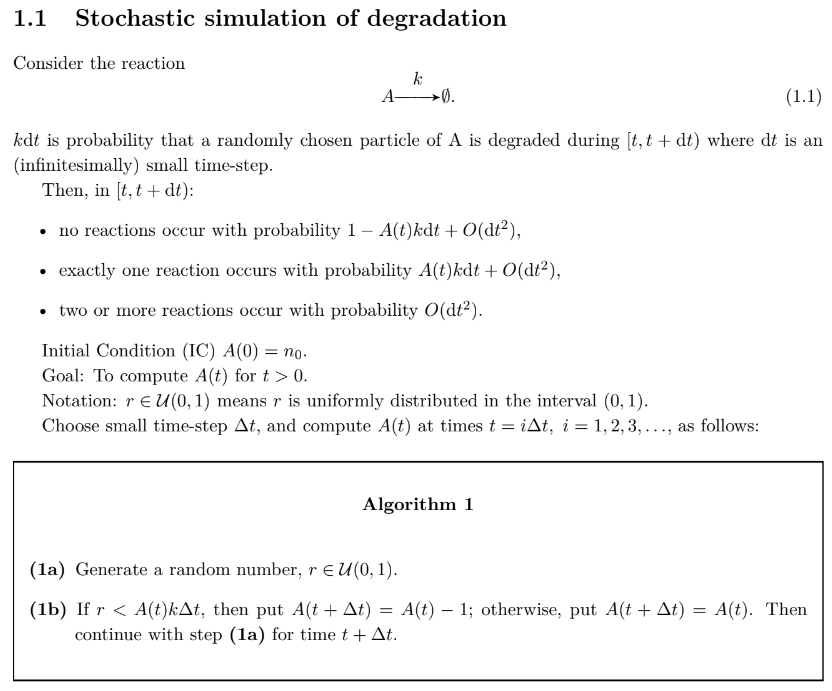

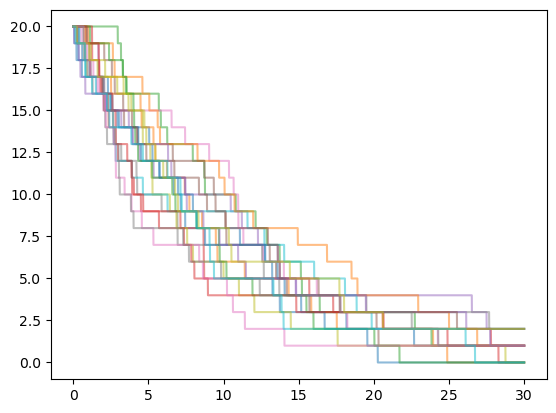

In [1]:
# degredation simulation
import numpy as np
import matplotlib.pyplot as plt

def alg1(n_0 = 20, k = 0.1, dt = 0.005, total_time = 30):
    t_arr = np.arange(0,total_time, step=dt)
    A_arr = np.zeros_like(t_arr)
    A_arr[0] = n_0
    c = 0
    while n_0 > 0 and c < len(A_arr) - 1:
        r = np.random.uniform(0,1)
        if r < A_arr[c]*k*dt:
            A_arr[c+1] = A_arr[c] - 1
        else:
            A_arr[c+1] = A_arr[c]

        c += 1

    return t_arr, A_arr

for i in range(20):
    t, A = alg1()
    plt.plot(t, A, alpha = 0.5)

## Using the time for next reaction instead of time steps
this is far more computationally efficient

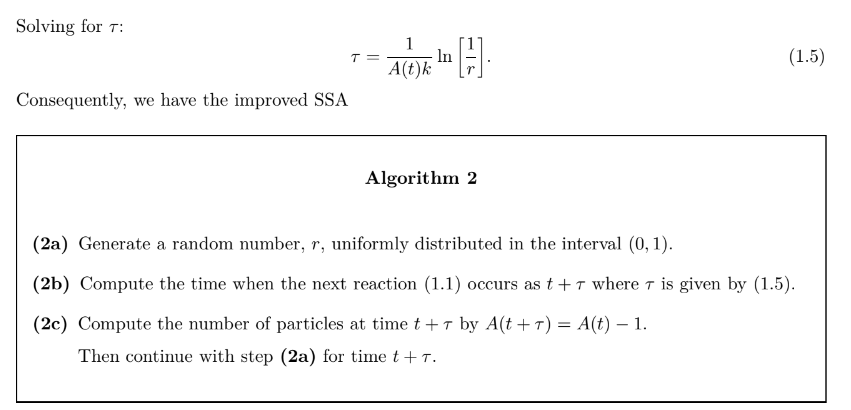

(0.0, 30.0)

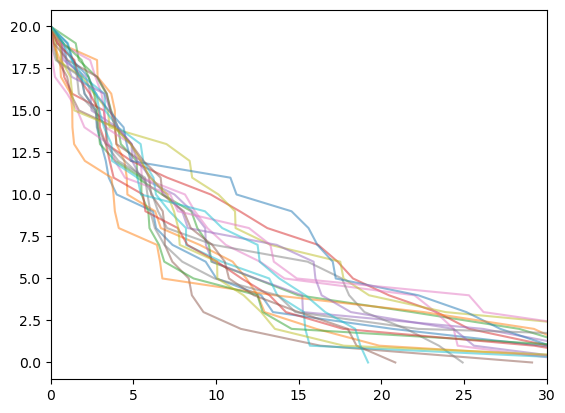

In [2]:
def alg2(n_0 = 20, k = 0.1, total_time = 30):
    time_arr = [0]
    A_arr = [n_0]
    c = 0
    while True:
        r = np.random.uniform(0,1)
        tau = np.log(1/r) / (A_arr[c]*k)

        time_arr.append(time_arr[-1] + tau)
        A_arr.append(A_arr[-1] - 1)
    
        if time_arr[-1] > total_time or A_arr[-1] == 0:
            break

        c += 1

    return time_arr, A_arr

for i in range(20):
    t, A = alg2()
    plt.plot(t, A, alpha = 0.5)

plt.xlim(0,30)

## Degredation and production algorithms

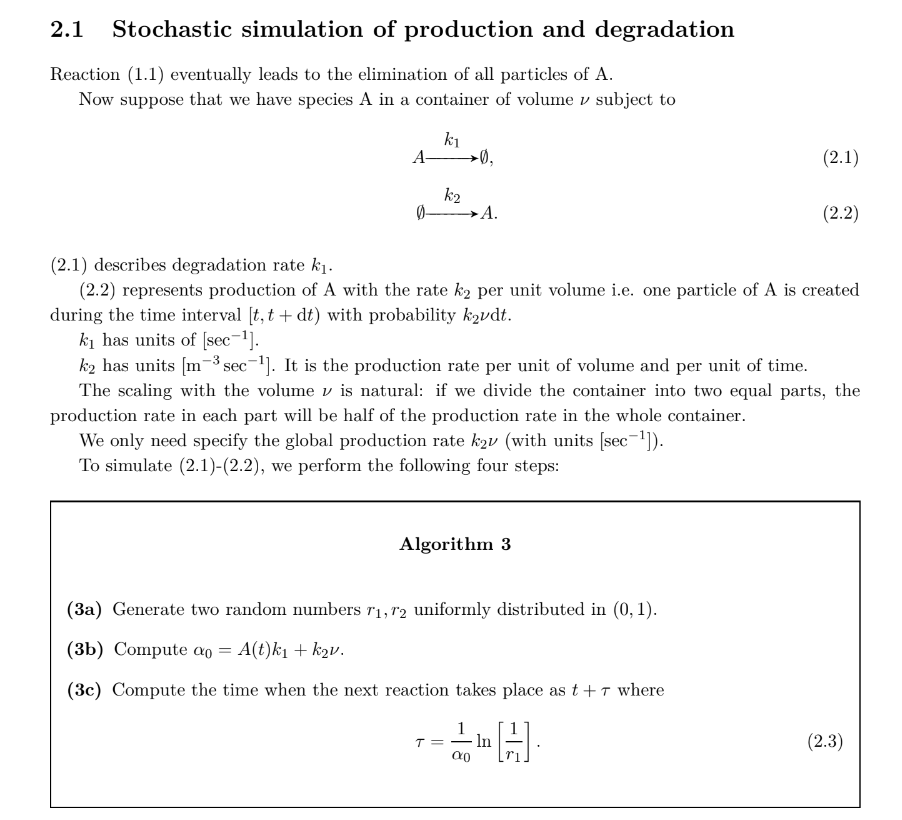

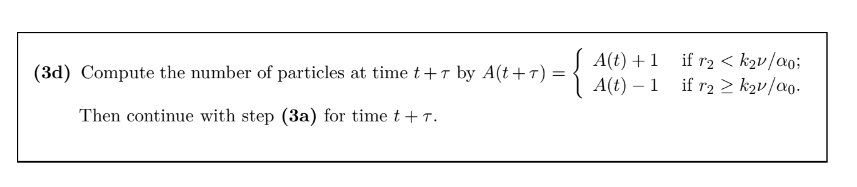

(0.0, 100.0)

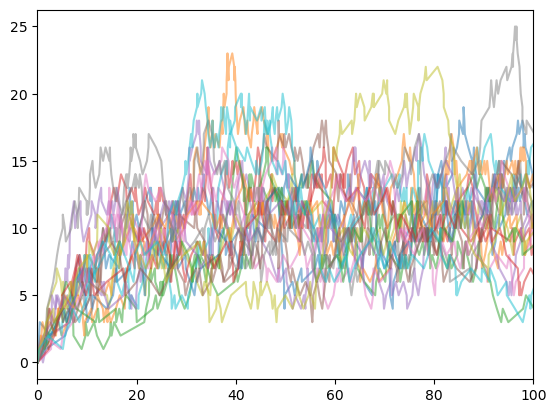

In [3]:
def alg3(n_0, k1, k2v, total_time):
    time_arr = [0]
    A_arr = [n_0]

    while True:
        r1 = np.random.uniform(0,1)
        r2 = np.random.uniform(0,1)

        alpha_0 = A_arr[-1] * k1 + k2v
        tau = np.log(1/r1) / alpha_0

        if r2 < (k2v)/alpha_0:
            A_arr.append(A_arr[-1] + 1)
        else:
            A_arr.append(A_arr[-1] - 1)

        time_arr.append(time_arr[-1] + tau)

        if time_arr[-1] > total_time:
            break

    return time_arr, A_arr

for i in range(20):
    t, A = alg3(0, 0.1, 1, 100)
    plt.plot(t, A, alpha = 0.5)

plt.xlim(0,100)

# Build probability distributions

In [4]:
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19


In [5]:
from fast_tools import get_dates, readc_day

dates = get_dates()
data = [readc_day(day) for day in dates]

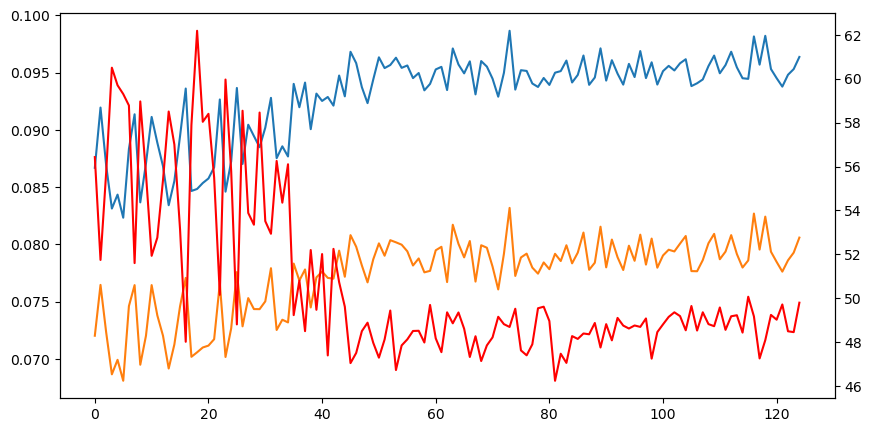

In [6]:
import matplotlib.pyplot as plt

lob_times = [np.diff(d[1]) for d in data]
mean_times = [np.mean(d) for d in lob_times]
std_times = [np.std(d) for d in lob_times]

plt.figure(figsize=(10,5))
plt.plot(mean_times)
plt.plot(std_times)
plt.twinx()
plt.plot([np.mean(np.sum(np.abs(d[0]), axis = 1)) for d in data], 'r')

In [7]:
diff_merge = np.concatenate(lob_times)
diff_merge.shape    

(41238568,)

[0.9977465512381516, 0.002251436082843614, 1.7459384137683927e-06, 2.182423017210491e-07, 2.424914463567212e-08, 2.424914463567212e-08, 0.0, 0.0, 0.0, 0.0]


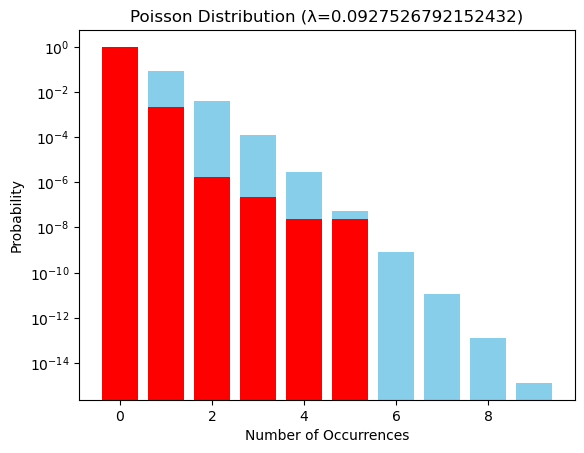

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters for the Poisson distribution
mu = np.mean(diff_merge)  # Mean parameter of the Poisson distribution

# Generate x values (number of occurrences)
step = 1
x = np.arange(0, 10, step=step)
prob_dist = []
for num in x:
    prob_dist.append(np.mean((diff_merge > (max(0,num-step/2))) & (diff_merge <= num+step/2)))

print(prob_dist)
# Calculate the probability mass function (PMF) of the Poisson distribution
pmf = poisson.pmf(x, mu)

# Plot the PMF
plt.bar(x, pmf, color='skyblue')
plt.bar(x, prob_dist, color="red")

# Add labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Probability')
plt.title(f'Poisson Distribution (λ={mu})')
plt.yscale("log")

# Show the plot
plt.show()


# Build Stochastic Model

In [43]:
def model1(time_rate, n_0 = 0, bid_ask_ratio = 0.5, max_time = 8.5*60*60):
    time_arr = [0]
    bid_arr = []
    ask_arr = []
    tap_time = [0]
    tapes_arr = [n_0]
    width = 50

    while True:
        n_bidask = len(bid_arr) + len(ask_arr)
        #print(f"{time_arr[-1]:.2f} | {n_bidask}", end="\r")
        r = np.random.uniform(0,1)
        tau = np.log(1/r) / (time_rate)
        time_arr.append(time_arr[-1] + tau)
        
        if np.random.uniform(0,1) <= 1/(1+np.exp(-(n_bidask-52))): # keeps the total number of orders around 52
            if np.random.uniform(0,1) <= (len(bid_arr)-15)/ (n_bidask - 15):
                if len(bid_arr) > 0:
                    bid_arr.remove(np.random.choice(bid_arr))
            else:
                if len(ask_arr) > 0:
                    ask_arr.remove(np.random.choice(ask_arr))

        else:
            if np.random.uniform(0,1) <= bid_ask_ratio: # if bid
                p = np.random.uniform(0,min(tapes_arr[-1] + width, 800))
                if len(ask_arr) > 0:
                    min_ask = min(ask_arr)
                    if min_ask <= p:
                        tapes_arr.append(min_ask)
                        tap_time.append(time_arr[-1])
                        ask_arr.remove(min_ask)
                    else:
                        bid_arr.append(p)
                else:
                    bid_arr.append(p)
            else:
                p = np.random.uniform(max(tapes_arr[-1] - width, 0),800)
                if len(bid_arr) > 0:
                    max_bid = max(bid_arr)
                    if max_bid >= p:
                        tapes_arr.append(max_bid)
                        tap_time.append(time_arr[-1])
                        bid_arr.remove(max_bid)
                    else:
                        ask_arr.append(p)
                else:
                    ask_arr.append(p)

        if time_arr[-1] > max_time:
            break

    return tap_time, tapes_arr, time_arr, bid_arr, ask_arr

test = model1(1/np.mean(diff_merge), n_0=0)

2.451800995715947


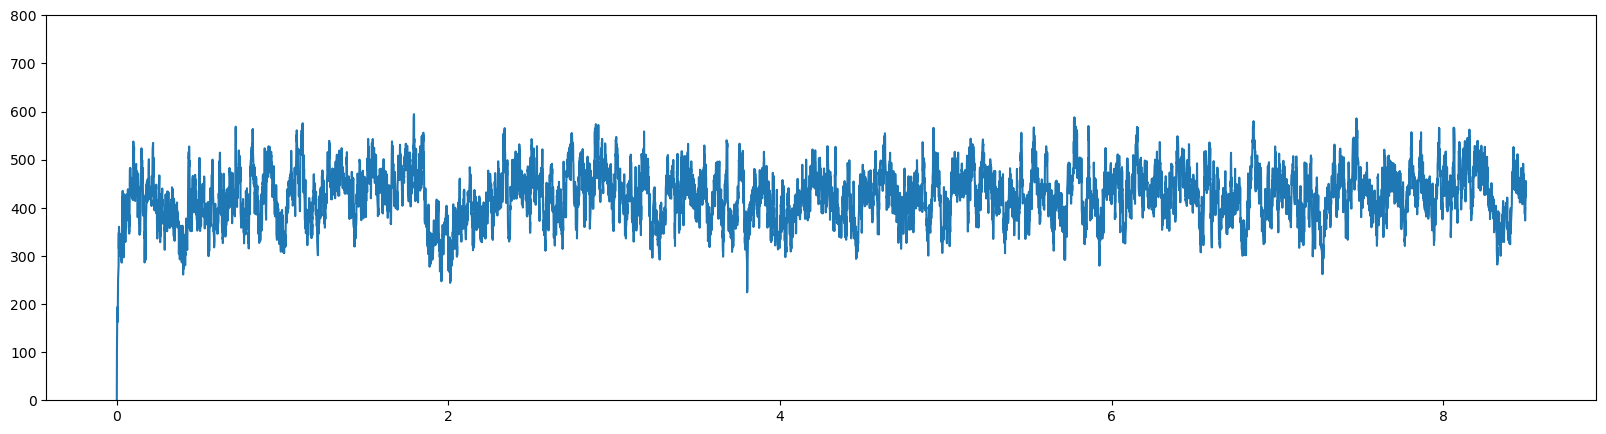

In [44]:
plt.figure(figsize=(20,5))
plt.plot(np.array(test[0]) / (60*60), test[1])
plt.ylim(0,800)
print(np.mean(np.diff(test[0])))

(array([7., 4., 2., 3., 2., 6., 0., 4., 2., 2.]),
 array([  1.91199401,  44.43536848,  86.95874294, 129.48211741,
        172.00549188, 214.52886634, 257.05224081, 299.57561528,
        342.09898974, 384.62236421, 427.14573868]),
 <BarContainer object of 10 artists>)

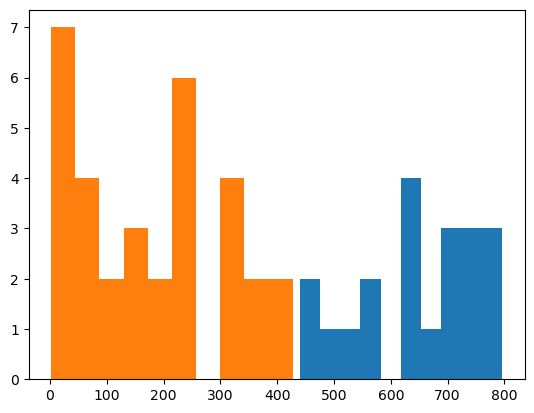

In [45]:
plt.hist(test[-1])
plt.hist(test[-2])

# Analyse Stochastic Model